# The sample codes for running RGD tomography

## define the functions

In [1]:
import numpy as np
import RGD
from BasicTools import Plt_Err_Time

from qibo.models.encodings import ghz_state


def qibo_Pauli_symbols(labels):
    """convert string representation of Pauli operator list
        to list of symbolic representation

    Args:
        labels (list): list of Pauli operator labels,
            (eg) list of Pauli terms  ["YXY", "IXX", "ZYI", "XXX", "YZZ"]
    Returns:
        list (Proj_list): list of symbolic Pauli operators
    """
    from functools import reduce

    from qibo.hamiltonians import SymbolicHamiltonian
    from qibo.symbols import I, X, Y, Z

    symbol_map = {
        "X": X,
        "Y": Y,
        "Z": Z,
        "I": I,
    }

    Proj_list = []
    for label in labels:
        qubitPauli = [symbol_map[Ps](i) for i, Ps in enumerate(label)]
        symbolPauli = SymbolicHamiltonian(reduce(lambda x, y: x * y, qubitPauli))
        Proj_list.append(symbolPauli)

    return Proj_list


def qibochem_measure_expectation(circuit, labels, num_shots):
    """Use qibochem.measurement package to get the expecation values
        of given list of Pauli terms for a particular given circuit

    Args:
        circuit (circuit): the circuit generating the state
        labels (list): list of Pauli operator labels,
            (eg) list of Pauli terms  ["YXY", "IXX", "ZYI", "XXX", "YZZ"]
        num_shots (int): number of shot measurements

    Returns:
        list (coef_Pauli_exact): list of exact expectation value of Pauli Terms
        list (coef_Pauli_shots): list of Pauli expectation from shot measurements
    """
    from functools import reduce

    from qibochem.measurement import expectation, expectation_from_samples

    from qibo.hamiltonians import SymbolicHamiltonian
    from qibo.symbols import I, X, Y, Z

    symbol_map = {
        "X": X,
        "Y": Y,
        "Z": Z,
        "I": I,
    }

    _circuit = circuit.copy()
    coef_Pauli_exact = []  # list of exact expectation value of Pauli Terms
    coef_Pauli_shots = []  # list of Pauli expectation from shot measurements
    for label in labels:
        print(f"label = {label}")

        qubitPauli = [symbol_map[Ps](i) for i, Ps in enumerate(label)]
        symbolPauli = SymbolicHamiltonian(reduce(lambda x, y: x * y, qubitPauli))

        coef_Pauli_exact.append(expectation(_circuit, symbolPauli))
        coef_Pauli_shots.append(
            expectation_from_samples(_circuit, symbolPauli, n_shots=num_shots)
        )

    return coef_Pauli_exact, coef_Pauli_shots


def generate_random_label(n, symbols=["I", "X", "Y", "Z"]):
    num_symbols = len(symbols)
    label = "".join([symbols[i] for i in np.random.randint(0, num_symbols, size=n)])
    return label

## choose the Pauli string (operator) for doing tomography

In [2]:
num_labels = 5      #  number of Pauli labels
n = 3               #  number of qubits
# labels = [generate_random_label(n) for i in range(num_labels)]

labels = ["YXY", "IXX", "ZYI", "XXX", "YZZ", "ZYY", "IXX", "XYY", "XZI"]
# labels = ['YZY', 'YYZ', 'XIY', 'IZY', 'YYY','XZI','IXZ','IIY','XXY','YZZ']
# labels = ['XXYY', 'YXZY', 'XZIZ', 'ZYYZ', 'YXYX', 'ZXXZ', 'ZIYZ', 'YXYY', 'YXYY', 'ZYYY']
# labels = ['ZIYZ', 'YXZX', 'ZIXX', 'YXYX', 'ZYXX']
# labels = ['IZZ', 'IIZ','ZIZ']    # NotImplementedError: Observable is not a Z Pauli string.

symProj_list = qibo_Pauli_symbols(labels)


[Qibo 0.2.17|INFO|2025-06-20 09:25:54]: Using qibojit (numba) backend on /CPU:0


## generate circuit & shot measurements

In [3]:
Nr = 1                                          #  rank of the target density matrix

stateGHZ = ghz_state(n)                         # generate GHZ state circuit
target_state_GHZ = stateGHZ.execute().state()   # get the state vector of the circuit
target_density_matrix = np.outer(target_state_GHZ, target_state_GHZ.conj())

num_shots = 200                                 # number of shot measurements

coef_Pauli_exact, measurement_list = qibochem_measure_expectation(
    stateGHZ, labels, num_shots
)                    # get the expectation values of Pauli terms (exact and from shots)
print(coef_Pauli_exact)
print(measurement_list)

label = YXY
label = IXX
label = ZYI
label = XXX
label = YZZ
label = ZYY
label = IXX
label = XYY
label = XZI
[np.float64(-0.9999999999999998), np.float64(0.0), np.float64(0.0), np.float64(0.9999999999999998), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-0.9999999999999998), np.float64(0.0)]
[np.float64(-1.0), np.float64(-0.04000000000000001), np.float64(0.11000000000000004), np.float64(1.0), np.float64(-0.03), np.float64(1.3877787807814457e-17), np.float64(0.0), np.float64(-1.0), np.float64(-0.14)]


## system parameters as the input to the RGD worker

In [4]:
params_dict = {
    "Nr": Nr,
    "target_DM": target_density_matrix,
    "labels": labels,
    "measurement_list": measurement_list,
    "symProj_list": symProj_list,
    "num_iterations": 150,
    "convergence_check_period": 1,
}

Ch_svd = -1  #   choice for initial SVD  (0: LA.svd, 1: svds, -1: rSVD)
InitX_RGD = 1  #   method of choosing initial X0

## running the RGD once collecting the input information

In [5]:
worker = RGD.BasicWorkerRGD(params_dict)
worker.computeRGD(InitX_RGD, Ch_svd)


[Qibo 0.2.17|WARNING|2025-06-20 09:39:03]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-06-20 09:39:03]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-06-20 09:39:03]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-06-20 09:39:03]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-06-20 09:39:03]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-06-20 09:39:03]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-06-20 09:39:03]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-06-20 09:39:03]: Calculating 

  self.coef = 0.9428090415820634
  InitX     = 1
 *********   using randomized-SVD  to construct  X0 = uk @ sDiag @ vkh  **************************
  ***   0-th (A A*) done:   Time --> ATQ: 4.38690185546875e-05,  AG: 3.1948089599609375e-05   ***
  ***   1-th (A A*) done:   Time --> ATQ: 3.600120544433594e-05,  AG: 3.0040740966796875e-05   ***
  ***   2-th (A A*) done:   Time --> ATQ: 2.9087066650390625e-05,  AG: 2.7179718017578125e-05   ***
  ***   3-th (A A*) done:   Time --> ATQ: 3.886222839355469e-05,  AG: 2.8848648071289062e-05   ***
  ***   4-th (A A*) done:   Time --> ATQ: 2.9087066650390625e-05,  AG: 2.5987625122070312e-05   ***
  ***   5-th (A A*) done:   Time --> ATQ: 2.6226043701171875e-05,  AG: 2.6702880859375e-05   ***
  ***   6-th (A A*) done:   Time --> ATQ: 2.7179718017578125e-05,  AG: 2.5987625122070312e-05   ***
  ***   7-th (A A*) done:   Time --> ATQ: 2.6941299438476562e-05,  AG: 2.7179718017578125e-05   ***
  ***   8-th (A A*) done:   Time --> ATQ: 2.717971801757812

## plot the error and time evolution of the RGD algorithm

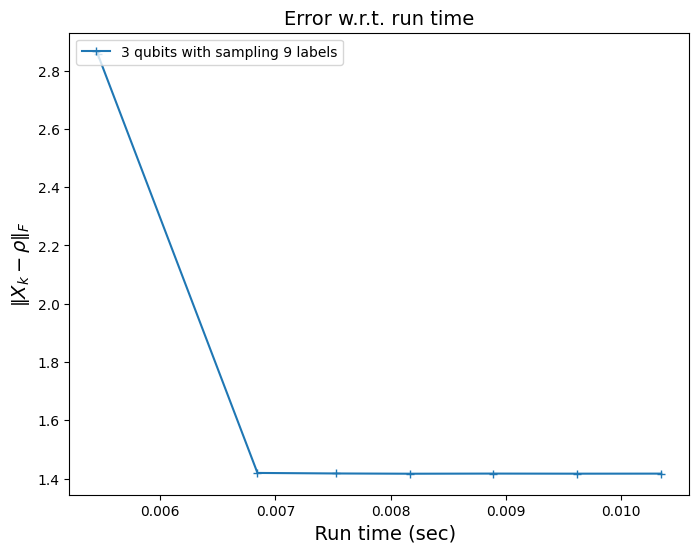

In [6]:
Plt_Err_Time(worker)    # plot the error and time evolution of the RGD algorithm
